# Giesekus Flow Curve: Shear-Thinning and the Mobility Parameter

> **From the [Giesekus Model Handbook](../../docs/source/models/giesekus/giesekus.rst):**  
> *"The Giesekus model (1982) is a nonlinear differential constitutive equation that extends the Upper-Convected Maxwell (UCM) model with a quadratic stress term representing anisotropic molecular mobility. The mobility parameter α controls shear-thinning: α = 0 recovers UCM (no shear-thinning), α = 0.5 gives maximum anisotropy."*

## What is the Giesekus Model?

The **Giesekus model** describes nonlinear viscoelastic behavior in polymer melts and solutions through anisotropic drag. Unlike the Upper-Convected Maxwell (UCM) model, which assumes isotropic molecular mobility, Giesekus accounts for the fact that stretched polymer chains slip more easily along their backbone than perpendicular to it.

**Key constitutive equation:**

$$
\boldsymbol{\tau} + \lambda \stackrel{\nabla}{\boldsymbol{\tau}} + \frac{\alpha \lambda}{\eta_p} \boldsymbol{\tau} \cdot \boldsymbol{\tau} = 2\eta_p \mathbf{D}
$$

where:
- $\boldsymbol{\tau}$ = polymer extra stress tensor (Pa)
- $\lambda$ = relaxation time (s)
- $\eta_p$ = polymer viscosity (Pa·s)
- **$\alpha$ = mobility parameter** (0 ≤ α ≤ 0.5) — controls shear-thinning and normal stresses
- $\stackrel{\nabla}{\boldsymbol{\tau}}$ = upper-convected derivative (frame-invariant time derivative)
- $\mathbf{D}$ = rate-of-deformation tensor

The **quadratic stress term** $\boldsymbol{\tau} \cdot \boldsymbol{\tau}$ represents anisotropic drag and generates:
1. **Shear-thinning viscosity**: η decreases with shear rate
2. **Non-zero second normal stress**: N₂ < 0 (diagnostic: N₂/N₁ = -α/2)
3. **Stress overshoot** in startup flow
4. **Faster-than-exponential** stress relaxation

**Physical motivation:** In polymer melts under shear, aligned chains experience anisotropic friction — they slide more easily along their contour than sideways. This anisotropy manifests as the α parameter.

## Learning Objectives

1. Fit the Giesekus model to real emulsion flow curve data
2. Understand the mobility parameter α and its effect on shear-thinning
3. Compute the critical Weissenberg number Wi_c ≈ 1/√α
4. Use NLSQ warm-start for efficient Bayesian inference with NUTS
5. Compare single-mode vs multi-mode Giesekus fitting

## Prerequisites

- Basic RheoJAX usage (basic/01-maxwell-fitting.ipynb)
- Bayesian inference fundamentals (bayesian/01-bayesian-basics.ipynb)

## Estimated Runtime

- **Fast demo** (NUM_CHAINS=1, NUM_SAMPLES=500): ~3-5 minutes
- **Full run** (NUM_CHAINS=4, NUM_SAMPLES=2000): ~15-20 minutes

## 1. Setup

In [1]:
# Google Colab setup
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
# Imports
%matplotlib inline
import gc
import json
import os
import sys
import time
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.giesekus import GiesekusMultiMode, GiesekusSingleMode

# Add examples root to path for shared utilities
sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

jax, jnp = safe_import_jax()
verify_float64()

# Suppress equinox DeprecationWarning (jax.core.mapped_aval/unmapped_aval deprecated in JAX 0.8+)
warnings.filterwarnings("ignore", message=".*jax\\.core\\.(mapped|unmapped)_aval.*", category=DeprecationWarning)

# CI/demo toggle: True = fast (fewer samples), False = production (full inference)
FAST_MODE = os.environ.get("FAST_MODE", "1") == "1"

print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")
print(f"FAST_MODE: {FAST_MODE}")

JAX version: 0.8.3
Devices: [CpuDevice(id=0)]
FAST_MODE: True


## 2. Theory: Giesekus Constitutive Model

The Giesekus model (1982) extends the Upper-Convected Maxwell (UCM) model by adding a **quadratic stress term** that accounts for anisotropic molecular interactions:

### Constitutive Equation

$$
\boldsymbol{\tau} + \lambda \stackrel{\nabla}{\boldsymbol{\tau}} + \frac{\alpha \lambda}{\eta_p} \boldsymbol{\tau} \cdot \boldsymbol{\tau} = 2\eta_p \mathbf{D}
$$

where:
- $\boldsymbol{\tau}$ = extra stress tensor (Pa)
- $\lambda$ = relaxation time (s)
- $\eta_p$ = polymer viscosity (Pa·s)
- $\alpha$ = mobility parameter (dimensionless, 0 ≤ α ≤ 0.5)
- $\stackrel{\nabla}{\boldsymbol{\tau}}$ = upper-convected derivative
- $\mathbf{D}$ = rate of deformation tensor

### Steady Shear Flow

For steady simple shear at rate $\dot{\gamma}$, the Giesekus model predicts:

**Shear stress:** $\sigma = \eta(\dot{\gamma}) \cdot \dot{\gamma}$

**Shear-thinning viscosity:**
$$
\eta(\dot{\gamma}) = \eta_s + \eta_p \frac{(1-f)^2}{1 + (1-2\alpha)f}
$$

where $f = f(\text{Wi}, \alpha)$ is a function of the Weissenberg number Wi = λγ̇.

### Key Physics

| Feature | Effect of α |
|---------|-------------|
| **Shear-thinning onset** | Wi_c ≈ 1/√α (earlier onset for larger α) |
| **High-shear slope** | Power-law exponent → -0.5 as Wi → ∞ |
| **Normal stresses** | N₂/N₁ = -α/2 (negative N₂ for α > 0) |
| **UCM limit** | α → 0: constant viscosity, N₂ = 0 |

### Parameters

| Parameter | Symbol | Units | Typical Range | Physical Meaning |
|-----------|--------|-------|---------------|------------------|
| `eta_p` | η_p | Pa·s | 0.1–10⁴ | Polymer viscosity contribution |
| `lambda_1` | λ | s | 10⁻³–10² | Relaxation time |
| `alpha` | α | — | 0–0.5 | Mobility/anisotropy parameter |
| `eta_s` | η_s | Pa·s | 0–10³ | Solvent viscosity |

**Zero-shear viscosity:** η₀ = η_p + η_s

## 3. Load Data

We use emulsion flow curve data at volume fraction φ = 0.80. This concentrated emulsion exhibits clear shear-thinning behavior suitable for Giesekus fitting.

In [3]:
# Load emulsion flow curve data
data_path = os.path.join("..", "data", "flow", "emulsions", "0.80.csv")
raw = np.loadtxt(data_path, delimiter=",", skiprows=1)
gamma_dot = raw[:, 0]
stress = raw[:, 1]

print(f"Loaded {len(gamma_dot)} data points")
print(f"Shear rate range: [{gamma_dot.min():.4f}, {gamma_dot.max():.1f}] 1/s")
print(f"Stress range: [{stress.min():.2f}, {stress.max():.2f}] Pa")

Loaded 30 data points
Shear rate range: [0.0016, 978.9] 1/s
Stress range: [23.69, 295.42] Pa


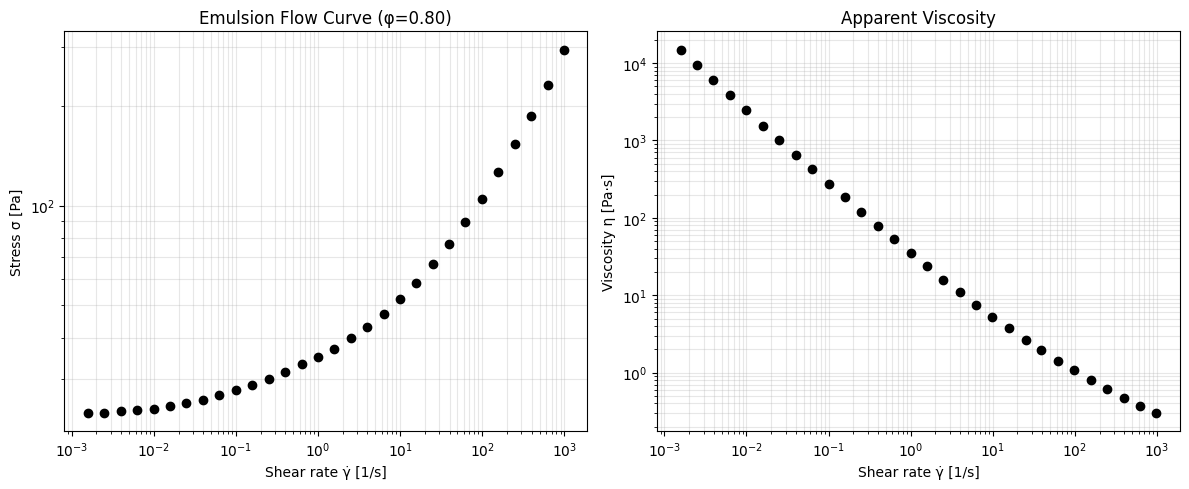

In [4]:
# Plot raw data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Stress vs shear rate
ax1.loglog(gamma_dot, stress, "ko", markersize=6)
ax1.set_xlabel("Shear rate γ̇ [1/s]")
ax1.set_ylabel("Stress σ [Pa]")
ax1.set_title("Emulsion Flow Curve (φ=0.80)")
ax1.grid(True, alpha=0.3, which="both")

# Viscosity vs shear rate
eta = stress / gamma_dot
ax2.loglog(gamma_dot, eta, "ko", markersize=6)
ax2.set_xlabel("Shear rate γ̇ [1/s]")
ax2.set_ylabel("Viscosity η [Pa·s]")
ax2.set_title("Apparent Viscosity")
ax2.grid(True, alpha=0.3, which="both")

plt.tight_layout()
display(fig)
plt.close(fig)

## 4. NLSQ Fitting

We first fit the Giesekus model using nonlinear least squares (NLSQ) to obtain point estimates. These will serve as warm-start values for Bayesian inference.

In [5]:
# Create and fit Giesekus model
model = GiesekusSingleMode()

t0 = time.time()
model.fit(gamma_dot, stress, test_mode="flow_curve")
t_nlsq = time.time() - t0

print(f"NLSQ fit time: {t_nlsq:.2f} s")
print(f"\nFitted parameters:")
param_names = ["eta_p", "lambda_1", "alpha", "eta_s"]
for name in param_names:
    val = model.parameters.get_value(name)
    print(f"  {name:10s} = {val:.4g}")

# Derived quantities
eta_p = model.parameters.get_value("eta_p")
eta_s = model.parameters.get_value("eta_s")
lambda_1 = model.parameters.get_value("lambda_1")
alpha = model.parameters.get_value("alpha")

eta_0 = eta_p + eta_s
if alpha > 0:
    Wi_c = 1.0 / np.sqrt(alpha)
    gamma_dot_c = Wi_c / lambda_1
    print(f"\nDerived quantities:")
    print(f"  η₀ = η_p + η_s = {eta_0:.2f} Pa·s")
    print(f"  Wi_c = 1/√α = {Wi_c:.2f}")
    print(f"  γ̇_c = Wi_c/λ = {gamma_dot_c:.2g} 1/s")

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=4 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.013892s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=66 | final_cost=0.6141 | elapsed=1.014s | final_gradient_norm=9.4280e-05


NLSQ fit time: 1.51 s

Fitted parameters:
  eta_p      = 2.482e+04
  lambda_1   = 1e+04
  alpha      = 0.004854
  eta_s      = 0.3728

Derived quantities:
  η₀ = η_p + η_s = 24816.52 Pa·s
  Wi_c = 1/√α = 14.35
  γ̇_c = Wi_c/λ = 0.0014 1/s


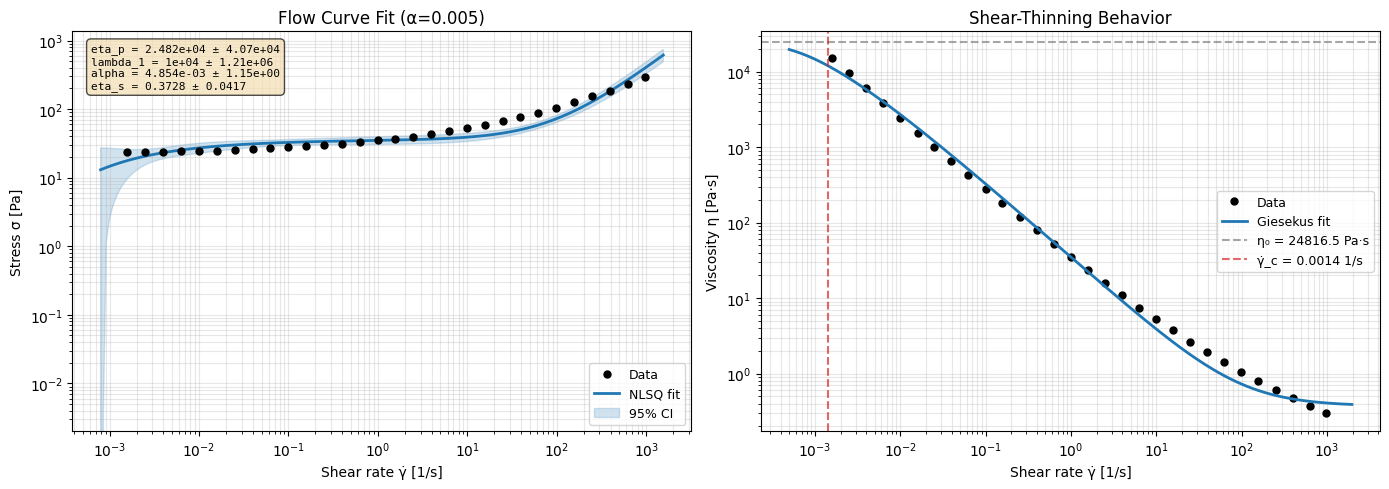

In [6]:
# Plot NLSQ fit with uncertainty band
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Stress with uncertainty band
plot_nlsq_fit(
    gamma_dot, stress, model, test_mode="flow_curve",
    param_names=param_names,
    xlabel="Shear rate γ̇ [1/s]", ylabel="Stress σ [Pa]",
    title=f"Flow Curve Fit (α={alpha:.3f})",
    ax=ax1,
)

# Viscosity (manual — derived quantity, not direct model output)
gamma_dot_fine = np.logspace(
    np.log10(gamma_dot.min()) - 0.5,
    np.log10(gamma_dot.max()) + 0.3,
    200,
)
stress_pred = model.predict(gamma_dot_fine, test_mode="flow_curve")
eta_pred = np.array(stress_pred) / gamma_dot_fine
eta = stress / gamma_dot

ax2.loglog(gamma_dot, eta, "ko", markersize=5, label="Data")
ax2.loglog(gamma_dot_fine, eta_pred, "-", lw=2, color="C0", label="Giesekus fit")
ax2.axhline(eta_0, color="gray", linestyle="--", alpha=0.7, label=f"η₀ = {eta_0:.1f} Pa·s")
if alpha > 0:
    ax2.axvline(gamma_dot_c, color="C3", linestyle="--", alpha=0.7,
                label=f"γ̇_c = {gamma_dot_c:.2g} 1/s")
ax2.set_xlabel("Shear rate γ̇ [1/s]")
ax2.set_ylabel("Viscosity η [Pa·s]")
ax2.set_title("Shear-Thinning Behavior")
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3, which="both")

plt.tight_layout()
display(fig)
plt.close(fig)

## 5. Bayesian Inference with NUTS

We use the NLSQ point estimates as warm-start values for efficient MCMC sampling with the No-U-Turn Sampler (NUTS).

In [7]:
# Bayesian inference with NLSQ warm-start
initial_values = {
    name: model.parameters.get_value(name)
    for name in param_names
}
print("Warm-start values:")
for k, v in initial_values.items():
    print(f"  {k}: {v:.4g}")

# FAST_MODE: quick CI validation; production: full inference
if FAST_MODE:
    NUM_WARMUP = 50
    NUM_SAMPLES = 100
    NUM_CHAINS = 1
else:
    NUM_WARMUP = 1000
    NUM_SAMPLES = 2000
    NUM_CHAINS = 4

gc.collect()

t0 = time.time()
result = model.fit_bayesian(
    gamma_dot,
    stress,
    test_mode="flow_curve",
    num_warmup=NUM_WARMUP,
    num_samples=NUM_SAMPLES,
    num_chains=NUM_CHAINS,
    initial_values=initial_values,
    seed=42,
    target_accept_prob=0.99,
)
t_bayes = time.time() - t0
print(f"\nBayesian inference time: {t_bayes:.1f} s")

Warm-start values:
  eta_p: 2.482e+04
  lambda_1: 1e+04
  alpha: 0.004854
  eta_s: 0.3728


  0%|          | 0/150 [00:00<?, ?it/s]

warmup:   1%|          | 1/150 [00:00<02:22,  1.05it/s, 1 steps of size 1.65e+00. acc. prob=0.00]

warmup:   7%|▋         | 11/150 [00:01<00:10, 13.63it/s, 255 steps of size 4.49e-05. acc. prob=0.64]

warmup:  11%|█▏        | 17/150 [00:01<00:06, 20.44it/s, 255 steps of size 7.50e-05. acc. prob=0.76]

warmup:  15%|█▌        | 23/150 [00:01<00:04, 26.92it/s, 255 steps of size 1.50e-04. acc. prob=0.82]

warmup:  19%|█▉        | 29/150 [00:01<00:03, 31.59it/s, 255 steps of size 9.01e-05. acc. prob=0.84]

warmup:  23%|██▎       | 35/150 [00:01<00:03, 35.42it/s, 255 steps of size 1.66e-04. acc. prob=0.87]

warmup:  27%|██▋       | 40/150 [00:01<00:02, 38.01it/s, 255 steps of size 2.11e-04. acc. prob=0.88]

warmup:  30%|███       | 45/150 [00:01<00:02, 40.07it/s, 255 steps of size 1.97e-04. acc. prob=0.89]

sample:  34%|███▍      | 51/150 [00:01<00:02, 43.49it/s, 255 steps of size 2.17e-03. acc. prob=1.00]

sample:  37%|███▋      | 56/150 [00:01<00:02, 44.35it/s, 255 steps of size 2.17e-03. acc. prob=1.00]

sample:  41%|████▏     | 62/150 [00:02<00:01, 46.21it/s, 255 steps of size 2.17e-03. acc. prob=1.00]

sample:  46%|████▌     | 69/150 [00:02<00:01, 50.06it/s, 255 steps of size 2.17e-03. acc. prob=1.00]

sample:  50%|█████     | 75/150 [00:02<00:01, 50.49it/s, 255 steps of size 2.17e-03. acc. prob=1.00]

sample:  54%|█████▍    | 81/150 [00:02<00:01, 50.43it/s, 255 steps of size 2.17e-03. acc. prob=1.00]

sample:  58%|█████▊    | 87/150 [00:02<00:01, 49.59it/s, 255 steps of size 2.17e-03. acc. prob=1.00]

sample:  62%|██████▏   | 93/150 [00:02<00:01, 48.76it/s, 255 steps of size 2.17e-03. acc. prob=1.00]

sample:  65%|██████▌   | 98/150 [00:02<00:01, 48.74it/s, 191 steps of size 2.17e-03. acc. prob=1.00]

sample:  69%|██████▊   | 103/150 [00:02<00:00, 48.23it/s, 255 steps of size 2.17e-03. acc. prob=1.00]

sample:  73%|███████▎  | 109/150 [00:03<00:00, 49.02it/s, 255 steps of size 2.17e-03. acc. prob=1.00]

sample:  76%|███████▌  | 114/150 [00:03<00:00, 48.29it/s, 255 steps of size 2.17e-03. acc. prob=1.00]

sample:  79%|███████▉  | 119/150 [00:03<00:00, 47.81it/s, 255 steps of size 2.17e-03. acc. prob=1.00]

sample:  83%|████████▎ | 125/150 [00:03<00:00, 48.41it/s, 255 steps of size 2.17e-03. acc. prob=1.00]

sample:  87%|████████▋ | 130/150 [00:03<00:00, 47.98it/s, 255 steps of size 2.17e-03. acc. prob=1.00]

sample:  90%|█████████ | 135/150 [00:03<00:00, 47.53it/s, 255 steps of size 2.17e-03. acc. prob=1.00]

sample:  93%|█████████▎| 140/150 [00:03<00:00, 47.36it/s, 255 steps of size 2.17e-03. acc. prob=1.00]

sample:  97%|█████████▋| 145/150 [00:03<00:00, 47.06it/s, 255 steps of size 2.17e-03. acc. prob=1.00]

sample: 100%|██████████| 150/150 [00:03<00:00, 47.06it/s, 255 steps of size 2.17e-03. acc. prob=1.00]

sample: 100%|██████████| 150/150 [00:03<00:00, 38.31it/s, 255 steps of size 2.17e-03. acc. prob=1.00]


Bayesian inference time: 6.9 s


## 6. Convergence Diagnostics

Check R-hat (target < 1.01) and effective sample size (ESS, target > 400 per chain).

In [8]:
# Convergence diagnostics table
diag = result.diagnostics

print("Convergence Diagnostics")
print("=" * 55)
print(f"{'Parameter':>12s}  {'R-hat':>8s}  {'ESS':>8s}  {'Status':>8s}")
print("-" * 55)

all_pass = True
for p in param_names:
    r_hat = diag.get("r_hat", {}).get(p, float("nan"))
    ess = diag.get("ess", {}).get(p, float("nan"))
    r_hat_ok = r_hat < 1.05
    ess_ok = ess > 100
    status = "PASS" if (r_hat_ok and ess_ok) else "CHECK"
    if status == "CHECK":
        all_pass = False
    print(f"{p:>12s}  {r_hat:8.4f}  {ess:8.0f}  {status:>8s}")

n_div = diag.get("divergences", diag.get("num_divergences", 0))
print(f"\nDivergences: {n_div}")
if all_pass and n_div == 0:
    print("\nAll convergence criteria PASSED")
else:
    print("\nCHECK REQUIRED: Increase num_warmup/num_samples")

Convergence Diagnostics
   Parameter     R-hat       ESS    Status
-------------------------------------------------------
       eta_p    1.2037         7     CHECK
    lambda_1    2.0071         4     CHECK
       alpha    1.0240        65     CHECK
       eta_s    1.0433        12     CHECK

Divergences: 0

CHECK REQUIRED: Increase num_warmup/num_samples


## 7. ArviZ Diagnostic Plots

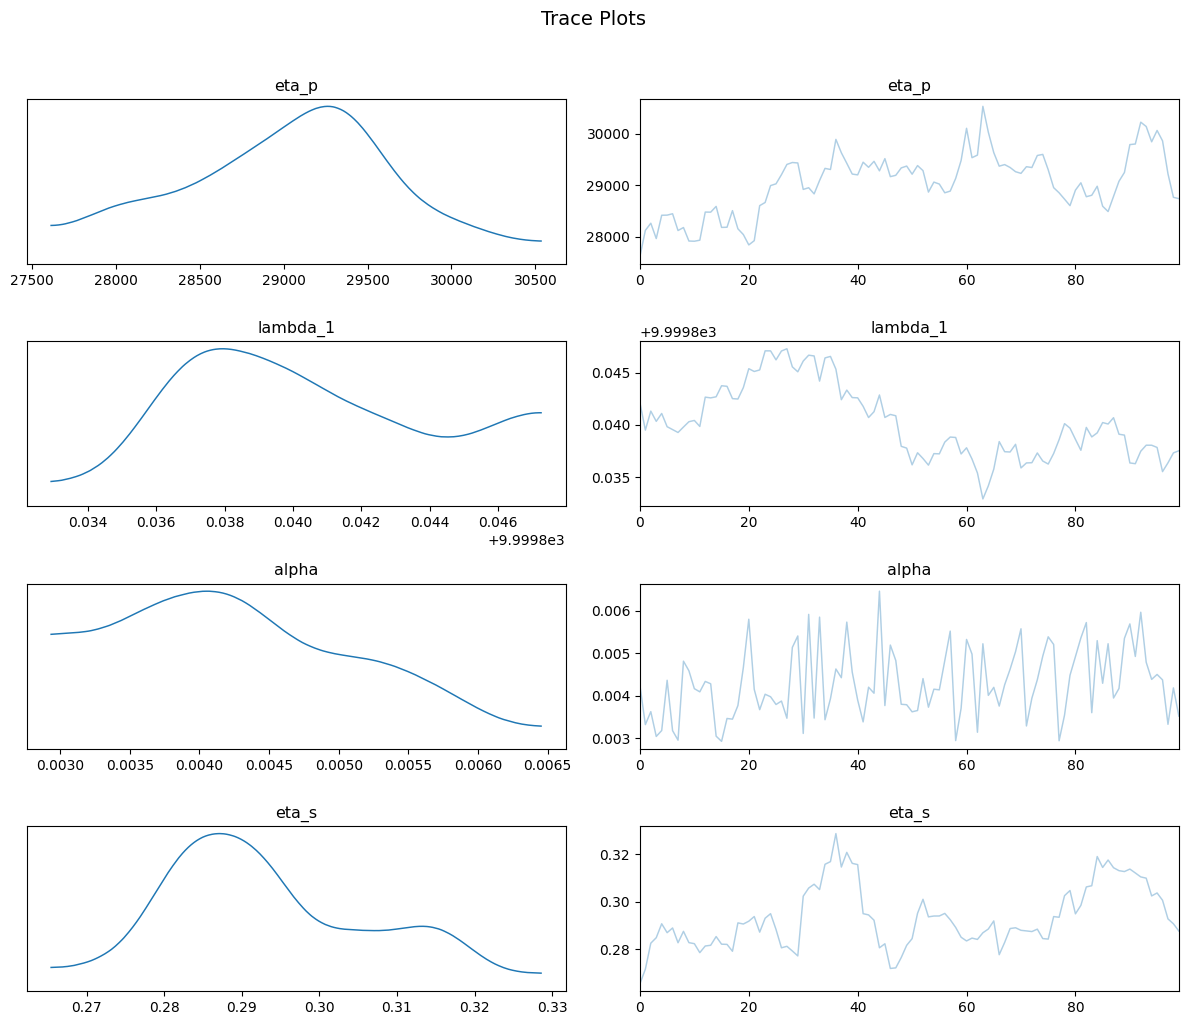

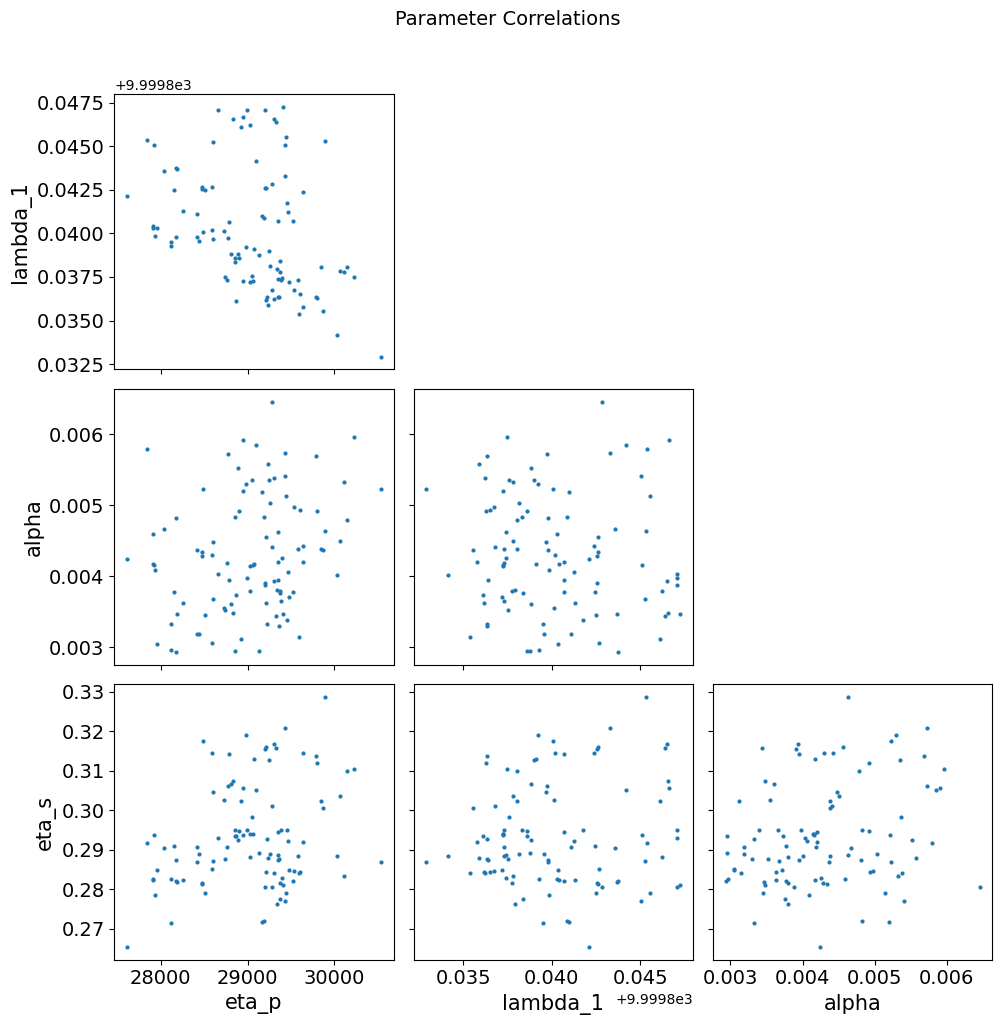

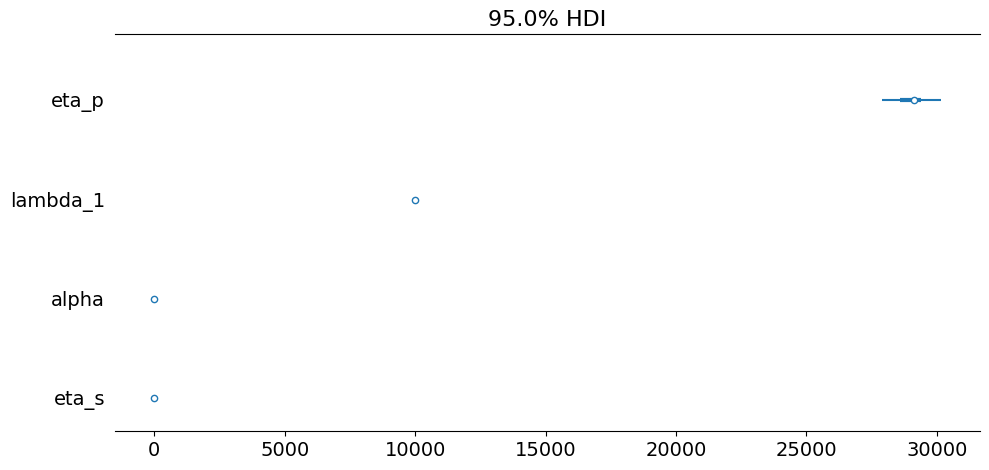

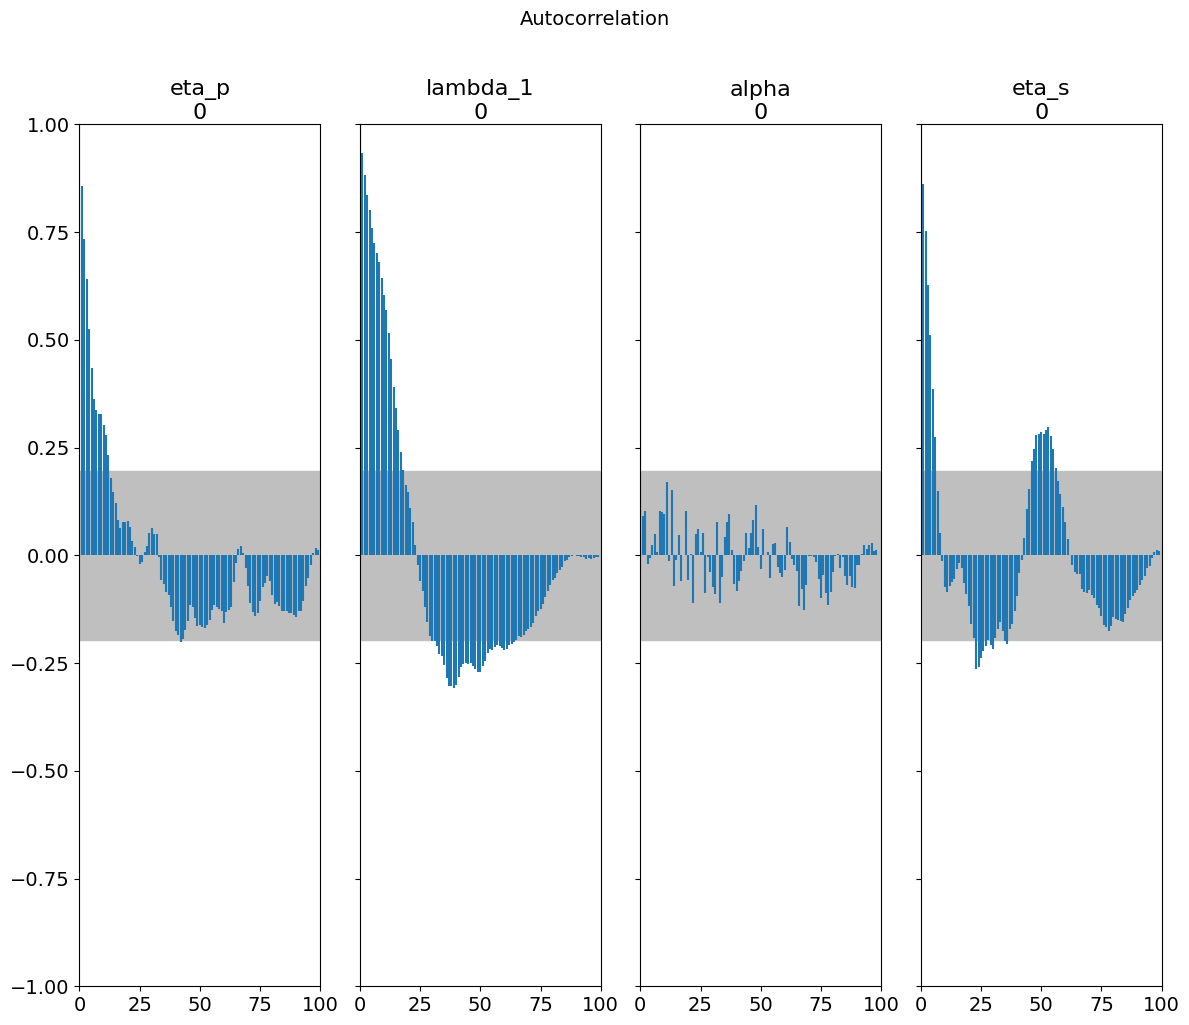

In [9]:
# Full ArviZ diagnostics: trace, pair, forest, energy, autocorr, rank
display_arviz_diagnostics(result, param_names, fast_mode=FAST_MODE)

## 8. Posterior Predictive Check

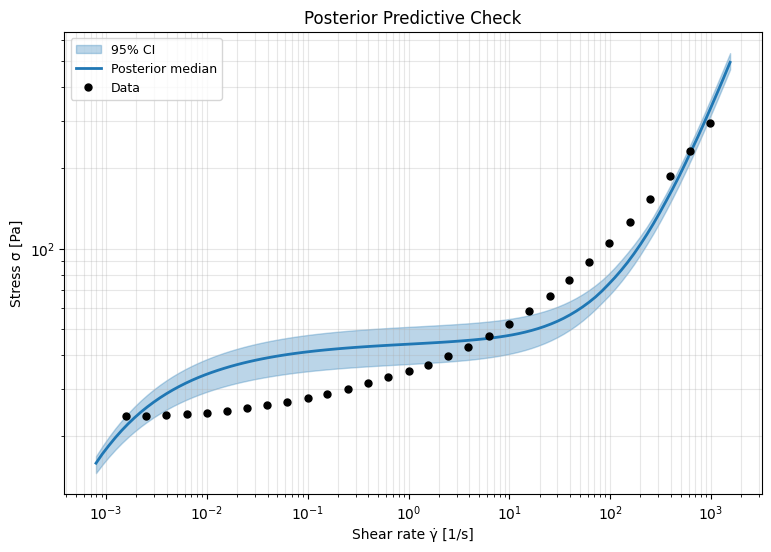

In [10]:
# Posterior predictive with 95% credible intervals
posterior = result.posterior_samples

fig, ax = plot_posterior_predictive(
    gamma_dot, stress, model, result,
    test_mode="flow_curve", param_names=param_names,
    xlabel="Shear rate γ̇ [1/s]", ylabel="Stress σ [Pa]",
    title="Posterior Predictive Check",
)
display(fig)
plt.close(fig)

## 9. Parameter Summary

In [11]:
# NLSQ vs Bayesian comparison table
print("Parameter Comparison: NLSQ vs Bayesian")
print("=" * 70)
print(f"{'Param':>12s}  {'NLSQ':>12s}  {'Bayes median':>14s}  {'95% CI':>26s}")
print("-" * 70)

for name in param_names:
    nlsq_val = model.parameters.get_value(name)
    bayes_samples = posterior[name]
    median = float(np.median(bayes_samples))
    lo = float(np.percentile(bayes_samples, 2.5))
    hi = float(np.percentile(bayes_samples, 97.5))
    print(f"{name:>12s}  {nlsq_val:12.4g}  {median:14.4g}  [{lo:.4g}, {hi:.4g}]")

# Derived quantities from posterior
alpha_samples = np.array(posterior["alpha"])
print(f"\nPosterior α statistics:")
print(f"  Mean: {np.mean(alpha_samples):.4f}")
print(f"  Std:  {np.std(alpha_samples):.4f}")
print(f"  N₂/N₁ = -α/2 = [{-np.percentile(alpha_samples, 97.5)/2:.4f}, {-np.percentile(alpha_samples, 2.5)/2:.4f}]")

Parameter Comparison: NLSQ vs Bayesian
       Param          NLSQ    Bayes median                      95% CI
----------------------------------------------------------------------
       eta_p     2.874e+04       2.911e+04  [2.791e+04, 3.013e+04]
    lambda_1         1e+04           1e+04  [1e+04, 1e+04]
       alpha      0.003524        0.004193  [0.002955, 0.00588]
       eta_s        0.2876          0.2906  [0.2719, 0.3183]

Posterior α statistics:
  Mean: 0.0043
  Std:  0.0008
  N₂/N₁ = -α/2 = [-0.0029, -0.0015]


## 10. Multi-Mode Comparison (Optional)

For broad relaxation spectra, multi-mode Giesekus may provide better fits. Let's briefly compare single-mode vs 3-mode fitting.

In [12]:
# Helper function to compute fit quality metrics
def compute_fit_quality(y_true, y_pred):
    """Compute R² and RMSE."""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    residuals = y_true - y_pred
    if y_true.ndim > 1:
        residuals = residuals.ravel()
        y_true = y_true.ravel()
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    r2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else 0.0
    rmse = np.sqrt(np.mean(residuals**2))
    return {"R2": r2, "RMSE": rmse}

# Multi-mode Giesekus (3 modes)
model_multi = GiesekusMultiMode(n_modes=3)

t0 = time.time()
model_multi.fit(gamma_dot, stress, test_mode="flow_curve")
t_multi = time.time() - t0

# Compute fit quality for both models
stress_single_pred = model.predict(gamma_dot, test_mode="flow_curve")
stress_multi_pred = model_multi.predict(gamma_dot, test_mode="flow_curve")

metrics_single = compute_fit_quality(stress, stress_single_pred)
metrics_multi = compute_fit_quality(stress, stress_multi_pred)

print(f"Multi-mode NLSQ fit time: {t_multi:.2f} s")
print(f"\nSingle-mode R²: {metrics_single['R2']:.6f}")
print(f"Multi-mode R²:  {metrics_multi['R2']:.6f}")

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=10 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.490600s


INFO:nlsq.least_squares:Convergence reason=`xtol` termination condition is satisfied. | iterations=26 | final_cost=0.0452 | elapsed=1.491s | final_gradient_norm=0.2758


Multi-mode NLSQ fit time: 2.28 s

Single-mode R²: 0.936234
Multi-mode R²:  0.991769


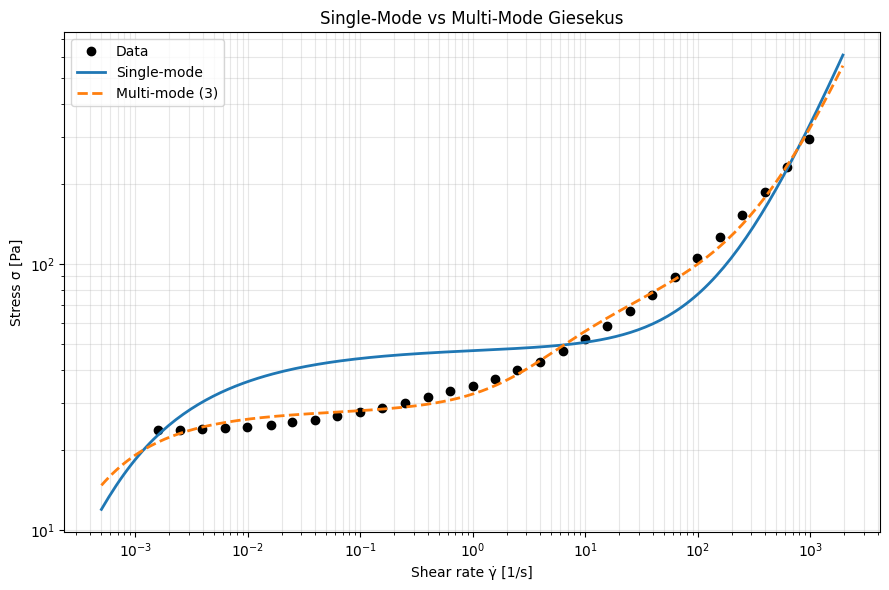

In [13]:
# Compare fits
stress_single = model.predict(gamma_dot_fine, test_mode="flow_curve")
stress_multi = model_multi.predict(gamma_dot_fine, test_mode="flow_curve")

fig, ax = plt.subplots(figsize=(9, 6))
ax.loglog(gamma_dot, stress, "ko", markersize=6, label="Data")
ax.loglog(gamma_dot_fine, stress_single, "-", lw=2, color="C0", label="Single-mode")
ax.loglog(gamma_dot_fine, stress_multi, "--", lw=2, color="C1", label="Multi-mode (3)")
ax.set_xlabel("Shear rate γ̇ [1/s]")
ax.set_ylabel("Stress σ [Pa]")
ax.set_title("Single-Mode vs Multi-Mode Giesekus")
ax.legend()
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
display(fig)
plt.close(fig)

## 11. Save Results

Save parameters for use in downstream notebooks (startup, LAOS, normal stresses).

In [14]:
# Save results for downstream notebooks
output_dir = os.path.join("..", "outputs", "giesekus", "flow_curve")
os.makedirs(output_dir, exist_ok=True)

# Save NLSQ point estimates (used by NB 03, 04, 07)
nlsq_params = {
    name: float(model.parameters.get_value(name))
    for name in param_names
}
with open(os.path.join(output_dir, "nlsq_params_flow_curve.json"), "w") as f:
    json.dump(nlsq_params, f, indent=2)

# Save posterior samples
posterior_dict = {k: np.array(v).tolist() for k, v in posterior.items()}
with open(os.path.join(output_dir, "posterior_flow_curve.json"), "w") as f:
    json.dump(posterior_dict, f)

print(f"Results saved to {output_dir}/")
print(f"  nlsq_params_flow_curve.json: {len(nlsq_params)} parameters")
print(f"  posterior_flow_curve.json: {len(alpha_samples)} draws")
print(f"\nThese parameters will be used by:")
print(f"  - NB 03: Startup shear (synthetic data)")
print(f"  - NB 04: Normal stresses (synthetic data)")
print(f"  - NB 07: LAOS (synthetic data)")

Results saved to ../outputs/giesekus/flow_curve/
  nlsq_params_flow_curve.json: 4 parameters
  posterior_flow_curve.json: 100 draws

These parameters will be used by:
  - NB 03: Startup shear (synthetic data)
  - NB 04: Normal stresses (synthetic data)
  - NB 07: LAOS (synthetic data)


## Key Takeaways

1. **Giesekus captures shear-thinning** via the quadratic stress term τ·τ. The mobility parameter α controls the onset and magnitude of shear-thinning.

2. **Critical Weissenberg number** Wi_c ≈ 1/√α marks the onset of significant shear-thinning. Larger α means earlier onset.

3. **Normal stress prediction**: N₂/N₁ = -α/2 is a key diagnostic. This will be explored in NB 04.

4. **UCM limit**: As α → 0, Giesekus reduces to Upper-Convected Maxwell with constant viscosity and N₂ = 0.

5. **Multi-mode Giesekus** can capture broader relaxation spectra but may be overparameterized for simple flow curves.

### When to Use Giesekus vs Other Models

| Material | Recommended Model | Reason |
|----------|------------------|--------|
| Polymer melts/solutions | **Giesekus** | Shear-thinning + normal stresses |
| Dilute polymer solutions | **Oldroyd-B** | Small α (nearly UCM) |
| Concentrated emulsions | **Giesekus** | Strong shear-thinning |
| Yield-stress fluids | **HL/DMT** | Thixotropy, yield stress |
| Soft glasses | **SGR** | Trap dynamics |

### Next Steps

- **NB 02**: SAOS (α-independent in linear regime)
- **NB 03**: Startup shear (stress overshoot)
- **NB 04**: Normal stresses (N₂/N₁ = -α/2)
- **NB 05**: Creep
- **NB 06**: Stress relaxation
- **NB 07**: LAOS (nonlinear oscillatory response)

## Further Reading

**RheoJAX Documentation:**
- [Giesekus Model Reference](../../docs/source/models/giesekus/giesekus.rst) — Complete theoretical handbook
- [Giesekus Index](../../docs/source/models/giesekus/index.rst) — Model overview and quick start

**Key References:**
1. Giesekus, H. (1982). "A simple constitutive equation for polymer fluids based on the concept of deformation-dependent tensorial mobility." *J. Non-Newtonian Fluid Mech.*, 11, 69-109. [doi:10.1016/0377-0257(82)85016-7](https://doi.org/10.1016/0377-0257(82)85016-7)

2. Bird, R.B., Armstrong, R.C., & Hassager, O. (1987). *Dynamics of Polymeric Liquids, Vol. 1: Fluid Mechanics.* 2nd ed. Wiley. Chapter 4.

3. Larson, R.G. (1988). *Constitutive Equations for Polymer Melts and Solutions.* Butterworths. Chapter 4.